We plot the eigenvalues for a smaple.

In [21]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.optimize import curve_fit, OptimizeWarning
import importlib.util
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils
from scipy.stats import linregress
import warnings


plt.rcParams.update({
    "text.usetex": False, # Disable LaTeX rendering
    "font.family": "serif", # Use a serif font
    # You might still request Computer Modern, Matplotlib will try to find it
    # if installed as a system font, otherwise fallback to another serif.
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm" # Use Computer Modern-like math fonts with mathtext
})

In [22]:
input_drive = "0.01"

input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)

# delta_scale = "linear"
delta_scale = "log-scale"

folder_paths = {
    100: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N100_z_{input_drive}/{input_type}/',
    125: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N125_z_{input_drive}/{input_type}/',
    167: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N167_z_{input_drive}/{input_type}/',
    250: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N250_z_{input_drive}/{input_type}/',
    500: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N500_z_{input_drive}/{input_type}/',
    1000: f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval_N1000_z_{input_drive}/{input_type}/'
}

In [23]:
# %% Define a function to load data from a folder
def load_data(folder_path):
    # This dictionary will map each tensor name (file name without .pt)
    # to a dictionary that maps deltaval values to the loaded tensor.
    all_data = {}
    # The regular expression below finds folders that contain the right mu and delta_scale,
    # and extracts the delta value.
    # pattern = re.compile(
    #     r'^(?=.*_mu_{})'
    #     r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(delta_scale))
    # )
    delta_vals = [0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]


    delta_pattern = "|".join(re.escape(str(delta)) for delta in delta_vals)

    # pattern = re.compile(
    #     r'^(?=.*_mu_{})'
    #     r'.*_delta_({})_{}$'.format(re.escape(mu), delta_pattern, re.escape(delta_scale))
    # )

    pattern = re.compile(
        r'^(?=.*_mu_{})'         # ensure somewhere in the string you have “_mu_<mu>”
        .format(re.escape(mu)) +
        r'.*_delta_({})(?:_.*)?$'  # capture only delta; allow _anything afterwards (or nothing)
        .format(delta_pattern)
    )

    representative_subfolder = None

    # Loop over all items in the main folder
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            match = pattern.search(subfolder)
            if match:
                representative_subfolder = subfolder
                # Convert the captured delta string to a float
                deltaval = float(match.group(1))
                
                # Loop over each file in the subfolder
                for filename in os.listdir(subfolder_path):
                    if filename.endswith('.pt'):
                        tensor_name = os.path.splitext(filename)[0]
                        tensor = torch.load(os.path.join(subfolder_path, filename))
                        if tensor_name not in all_data:
                            all_data[tensor_name] = {}
                        all_data[tensor_name][deltaval] = tensor

    # Load parameters from a representative subfolder
    param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
    with open(param_file_path, 'r') as f:
        params = json.load(f)
    
    # For example, we are interested in the eigenvalue data.
    eigvals_dict = all_data['eigvals_J']
    return eigvals_dict, params

# %% Load data for each N into a new dictionary.
data_by_N = {}
for N_val, folder_path in folder_paths.items():
    eigvals_dict, params = load_data(folder_path)
    data_by_N[N_val] = {
         'eigvals_dict': eigvals_dict,
         'params': params
    }

data_by_N

# %% Build a set of all delta values available across different N folders.
all_delta_vals = set()
for data in data_by_N.values():
    all_delta_vals.update(data['eigvals_dict'].keys())
all_delta_vals = sorted(all_delta_vals)


In [24]:
delta_val = 0.2

In [29]:
results_for_plotting = {}
sorted_N_values = sorted(data_by_N.keys())

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(sorted_N_values), vmax=max(sorted_N_values))

# Loop through each system size N
for N in sorted_N_values:
    if delta_val not in data_by_N[N]['eigvals_dict']:
        print(f"  Skipping N = {N}: delta_val = {delta_val} not found in 'eigvals_dict'.")
        continue

    eigvals_tensor = data_by_N[N]['eigvals_dict'][delta_val].squeeze()
    all_nan_rows_mask = torch.all(torch.isnan(eigvals_tensor), dim=1)
    eigvals_tensor = eigvals_tensor[~all_nan_rows_mask]

    num_trials, num_eigvals = eigvals_tensor.shape
    sorted_real_parts, _ = torch.sort(eigvals_tensor.real, dim=1, descending=True)
    sorted_real_parts = sorted_real_parts.numpy()
    avg_ranked_eigvals = np.nanmean(sorted_real_parts, axis=0)

    ranks = np.arange(num_eigvals)
    normalized_ranks = ranks / (num_eigvals - 1)
    results_for_plotting[N] = (normalized_ranks, avg_ranked_eigvals)
    # results_for_plotting[N] = (ranks, avg_ranked_eigvals)

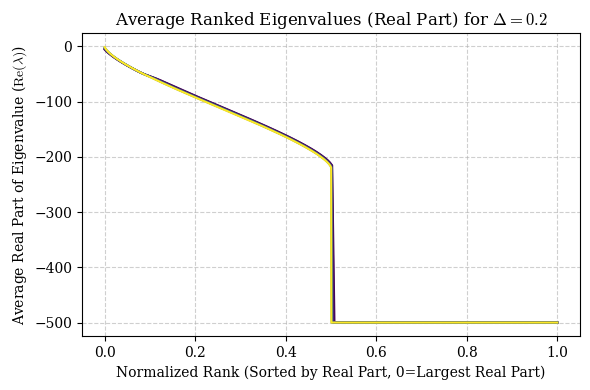

In [30]:
# 6. Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# N_vals = [500, 1000]
N_vals = sorted_N_values

for N in N_vals:
    normalized_ranks, avg_real_eigvals = results_for_plotting[N]
    ax.plot(
        normalized_ranks,
        avg_real_eigvals,
        # marker='o',       # Add markers to distinguish points
        linestyle='-',    # Connect markers with lines
        markersize=4,     # Adjust marker size
        label=f'N = {N}',
        color=cmap(norm(N)) # Assign color based on N
    )

ax.set_xlabel('Normalized Rank (Sorted by Real Part, 0=Largest Real Part)')
ax.set_ylabel('Average Real Part of Eigenvalue ($\mathrm{Re}(\lambda)$)') # Use LaTeX for Re
ax.set_title(f'Average Ranked Eigenvalues (Real Part) for $\\Delta = {delta_val}$') # Use LaTeX for delta
# ax.legend(title="System Size (N)", loc='best')
ax.grid(True, linestyle='--', alpha=0.6) # Add grid for readability
# ax.set_xlim(-0.01, 0.01) # Set x-axis limi ts
# ax.set_ylim(-20, 0) # Set y-axis limits

# ax.set_xlim(-0.01, 1000) # Set x-axis limi ts
# ax.set_ylim(-200, 0) # Set y-axis limits

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()